# Audio Predictor Evaluation
This notebook helps to see how audio predictor synthesize voice using existing phonemes

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
import math
import textgrid
import random

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio, display
from vocos import Vocos

# Local
from training.misc import plot_specgram, plot_waveform
from training.dataset import create_single_sampler
from supervoice.audio import spectogram, load_mono_audio
from supervoice.model_audio import AudioPredictor
from supervoice.tokenizer import Tokenizer
from supervoice.tensors import drop_using_mask
from supervoice.config import config
from supervoice.alignment import compute_alignments

In [2]:
device = "cpu"

# Vocoder
vocoder = torch.hub.load(repo_or_dir='ex3ndr/supervoice-vocoder', model='bigvsan')
vocoder = vocoder.to(device)
def do_vocoder(src):
    with torch.no_grad():
        return vocoder.generate(src)

flow = torch.hub.load(repo_or_dir='ex3ndr/supervoice-flow', model='flow')

# GPT
phonemizator = torch.hub.load(repo_or_dir='ex3ndr/supervoice-gpt', model='phonemizer')

# Tokenizer
tokenizer = Tokenizer(config)
phoneme_duration = config.audio.hop_size / config.audio.sample_rate

Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-vocoder_master
Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-flow_main
Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-gpt_master


In [3]:
# sampler = create_single_sampler(["eval"])
# sample_id = 3
# sample_condition_id = 1107

sampler = create_single_sampler(["librilight-small"])
sample_id = 3
# sample_condition_id = 1107
sample_condition_id = 1212

# sampler = create_single_sampler(["hifi-tts"])
# sample_id = 200070
# sample_condition_id = 1107

In [4]:
def extract_tokens(src, style, audio, condition = False):
    aligned_phonemes = compute_alignments(config, src, style, audio.shape[1], not condition)
    phonemes = []
    styles = []
    for t in aligned_phonemes:
        for i in range(t[1]):
            phonemes.append(t[0])
            styles.append(0)
    tokens = tokenizer(phonemes)
    return tokens, phonemes, torch.tensor(styles)

def audio_denormalize(src):
    return (src * config.audio.norm_std) + config.audio.norm_mean

def audio_normalize(src):
    return (src - config.audio.norm_mean) / config.audio.norm_std

def do_spectogram(src):
    return spectogram(src, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.mel_norm, config.audio.mel_scale, config.audio.sample_rate)

def empty_tokens(size):
    return torch.zeros((size)).long().to(device)

def empty_mask(size):
    return torch.ones((size)).bool().to(device)

def do_sample(id):
    (spec, style, tg) = sampler(id)
    spec = spec.T
    tokens, _, token_styles = extract_tokens(tg, style, spec)
    spec = spec[:, :len(tokens)]
    spec = spec.to(device)
    token_styles = token_styles.to(device)
    tokens = tokens.to(device)
    return (spec, tokens, token_styles)

### Load Model

In [5]:
model = AudioPredictor(flow, config)
model = model.to(device)
checkpoint = torch.load(f'./output/direct-02.pt', map_location="cpu")
model.load_state_dict(checkpoint['model'])
model.eval()
print("Predictor at ", checkpoint['step'])

Predictor at  109000


### Load audio with phonemes
This loads sample audio that we would be able to use to compare with synthesized one

Source Audio


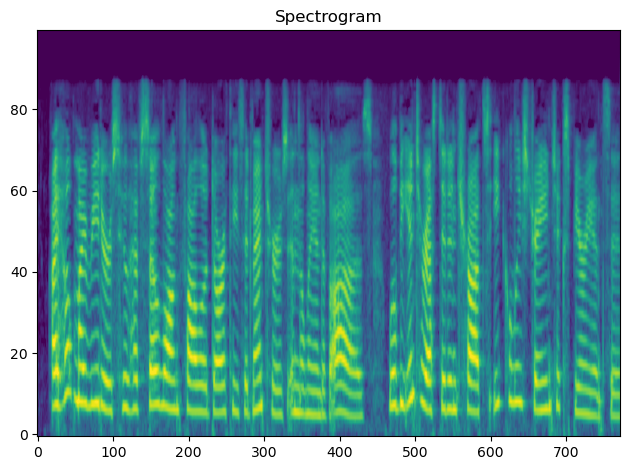

In [6]:
(spec, tokens, style) = do_sample(sample_id)

print("Source Audio")
display(Audio(data=do_vocoder(spec).cpu(), rate=config.audio.sample_rate))
plot_specgram(spec.cpu())

Conditioning Audio


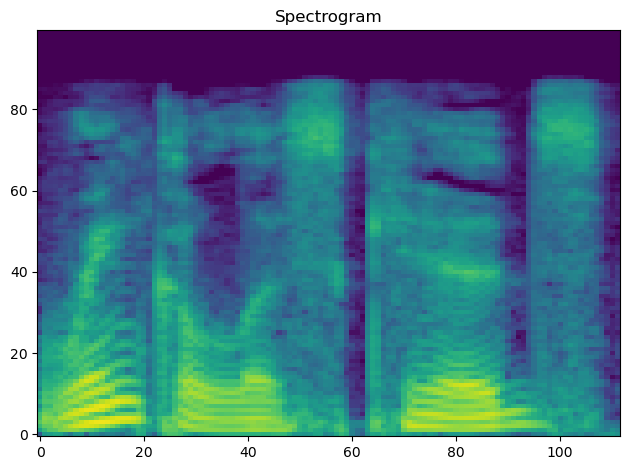

In [7]:
(cond_spec, cond_tokens, cond_style) = do_sample(1212)

print("Conditioning Audio")
display(Audio(data=do_vocoder(cond_spec).cpu(), rate=config.audio.sample_rate))
plot_specgram(cond_spec.cpu())

# Synthesize voice from phonemes
This synthesizes random voice from existing phonemes (taken from another file)

Output


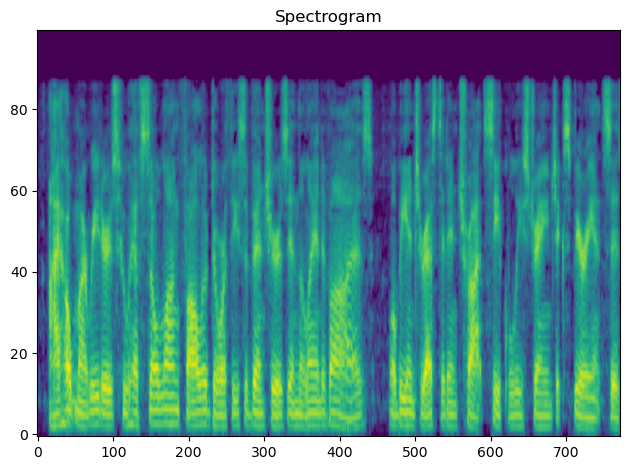

In [12]:
with torch.no_grad():

    # Params
    s_steps = 8
    s_alpha = 0.2
    s_tokens = tokens
    s_tokens_style = style + 1
    s_audio = torch.zeros((len(tokens), config.audio.n_mels)).to(device)
    s_mask = empty_mask(len(tokens))

    # Synthesize
    sample, trajectory = model.sample(tokens = s_tokens, tokens_style = s_tokens_style, audio = s_audio, mask = s_mask, steps = s_steps, alpha = s_alpha)
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)

print("Output")
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)
display(Audio(data=resynth, rate=config.audio.sample_rate))
plot_specgram(sample.transpose(1,0).cpu())

### Restore segment
Cut part of the audio and re-generate segment

(0, 463)
Restored audio


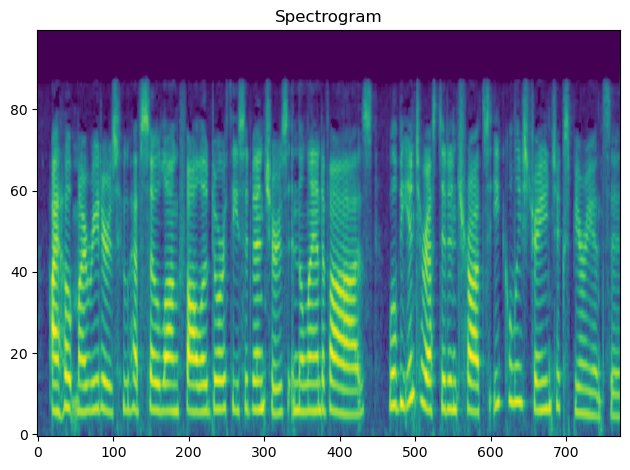

In [9]:
with torch.no_grad():

    # Params
    s_steps = 16
    s_alpha = 0.7
    s_tokens = tokens
    s_tokens_style = style + 1
    s_audio = audio_normalize(spec.transpose(1,0))

    # Mask
    seq_len = len(tokens)
    interval = (math.floor(seq_len * 0), math.floor(seq_len * 0.6))
    print(interval)
    s_mask = torch.zeros((seq_len)).bool().to(device)
    s_mask[interval[0]: interval[1]] = True
    s_audio = drop_using_mask(s_audio, 0, s_mask)

    # Restore audio
    sample, trajectory = model.sample(tokens = s_tokens, tokens_style = s_tokens_style, audio = s_audio, mask = s_mask, steps = s_steps, alpha = s_alpha)
    # sample = audio_denormalize(sample) * 1.2
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Restored audio")
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
plot_specgram(sample.transpose(1,0).cpu())
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

### Conditioned TTS

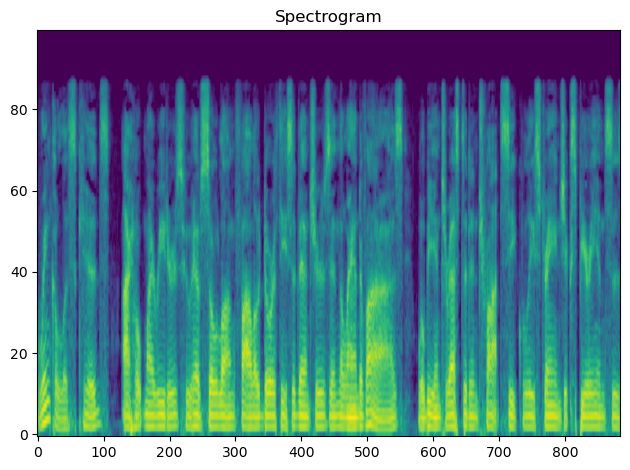

In [10]:
# TTS
def conditioned_tts(tokens, steps = 16, alpha = 0.7):
    with torch.no_grad():

        # Create tokens
        s_audio = torch.cat([
            audio_normalize(cond_spec.transpose(1,0)), 
            torch.zeros(len(tokens), config.audio.n_mels, device=device)
        ])
        s_tokens = torch.cat([
            cond_tokens, 
            tokens, 
        ])
        s_tokens_style = torch.cat([
            cond_style + 1, 
            style + 1, 
        ])

        # Create a mask
        s_mask = torch.zeros((len(cond_tokens) + len(tokens))).bool().to(device)
        s_mask[len(cond_tokens):len(s_mask)] = True

        # Restore audio
        sample, trajectory = model.sample(tokens = s_tokens, tokens_style = s_tokens_style, audio = s_audio, mask = s_mask, steps = steps, alpha = alpha)
        sample = audio_denormalize(sample)
        trajectory = audio_denormalize(trajectory)
        # sample = sample[len(cond_tokens):-2] * 1.2
        # sample = sample * 1.2
        trajectory = trajectory[:,len(cond_tokens):]
        
        return sample, trajectory
sample, trajectory = conditioned_tts(tokens)

# Visualize
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)
display(Audio(data=resynth, rate=config.audio.sample_rate))
plot_specgram(sample.transpose(1,0).cpu())